In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
import xgboost as xgb

In [4]:
xgb.__version__

'1.1.1'

In [5]:
DATA_DIR_PATH = os.path.join('..', '..', 'data')

def laod_data(file_name):
  file_path = os.path.join(DATA_DIR_PATH, file_name)
  return pd.read_csv(file_path, header=0)

In [6]:
df_train = laod_data('bookmark_train_data.csv')
print(len(df_train))
df_train.head(3)

199


,ncode,title,category,bookmark_cat,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,...,wc_その他-間投,wc_名詞-固有名詞-人名-名,wc_助動詞,wc_助詞-接続助詞,wc_名詞-代名詞-一般,wc_副詞-一般,wc_名詞-接続詞的,wc_名詞-固有名詞-組織,wc_記号-句点,rating
0,n4366gd,雷帝の軌跡 ～俺だけ使える【雷魔術】で最強の魔術師を目指します～,ハイファンタジー〔ファンタジー〕,1,1.586338e+09,1.593468e+09,92340,3840,28950,992220,...,0,30,4680,2250,900,570,0,0,1830,3.0
1,n7336gg,星斬りの剣士,ハイファンタジー〔ファンタジー〕,1,1.590714e+09,1.593338e+09,77880,4140,4950,863400,...,0,90,4320,1620,1590,390,0,60,2280,4.0
2,n9677fw,落ちこぼれ国を出る〜実は世界で４人目の付与術師だった件について〜,ハイファンタジー〔ファンタジー〕,1,1.575176e+09,1.593429e+09,59880,3090,10230,628470,...,0,240,2490,1260,450,360,30,0,930,3.0


In [7]:
df_test = laod_data('ranking_test_data.csv')
print(len(df_test))
df_test.head(3)

65


,ncode,title,category,bookmark_cat,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,...,wc_動詞-非自立,wc_助詞-並立助詞,wc_接頭詞-数接続,wc_名詞-接続詞的,wc_形容詞-自立,wc_名詞-固有名詞-人名-一般,wc_記号-括弧開,wc_名詞-固有名詞-人名-名,wc_名詞-接尾-形容動詞語幹,rating
0,n8642gc,聖貨を集めて、ぶん回せ！,ハイファンタジー〔ファンタジー〕,-1,1.585469e+09,1.593763e+09,37740,2310,0,383130,...,30,240,0,0,270,30,480,60,0,-1
1,n8693gg,十年目、帰還を諦めた転移者はいまさら主人公になる,ハイファンタジー〔ファンタジー〕,-1,1.591009e+09,1.593774e+09,144330,5760,44100,1561170,...,1680,60,0,0,1710,0,1800,270,60,-1
2,n4452ge,俺だけレベルが上がる世界で悪徳領主になっていた,ハイファンタジー〔ファンタジー〕,-1,1.587737e+09,1.593006e+09,156720,6210,13290,1636680,...,1890,180,0,0,930,60,810,0,60,-1


In [8]:
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
cat_le.fit(df_train['category'])


def data_preprocess(df):
  new_df = df.drop(['ncode', 'title', 'bookmark_cat'], axis=1)

  new_df['category'] = cat_le.transform(new_df['category'])

  return new_df

In [9]:
df_train2 = data_preprocess(df_train)
df_train2.head(3)

,category,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,avg_char_count,avg_new_line_count,avg_talk_char_count,...,wc_その他-間投,wc_名詞-固有名詞-人名-名,wc_助動詞,wc_助詞-接続助詞,wc_名詞-代名詞-一般,wc_副詞-一般,wc_名詞-接続詞的,wc_名詞-固有名詞-組織,wc_記号-句点,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,992220,3078.0,128.0,965.0,...,0,30,4680,2250,900,570,0,0,1830,3.0
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,863400,2596.0,138.0,165.0,...,0,90,4320,1620,1590,390,0,60,2280,4.0
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,628470,1996.0,103.0,341.0,...,0,240,2490,1260,450,360,30,0,930,3.0


In [10]:
X = df_train2.drop(['rating'], axis=1).values
y = df_train2['rating'].values
print(X.shape, y.shape)

(199, 129) (199,)


In [11]:
df_train2.keys()

Index(['category', 'created_at', 'updated_at', 'sum_char_count',
       'sum_new_line_count', 'sum_talk_char_count', 'sum_word_count',
       'avg_char_count', 'avg_new_line_count', 'avg_talk_char_count',
       ...
       'wc_その他-間投', 'wc_名詞-固有名詞-人名-名', 'wc_助動詞', 'wc_助詞-接続助詞', 'wc_名詞-代名詞-一般',
       'wc_副詞-一般', 'wc_名詞-接続詞的', 'wc_名詞-固有名詞-組織', 'wc_記号-句点', 'rating'],
      dtype='object', length=130)

In [12]:
print(y)

[3.   4.   3.   4.   3.   3.   3.   4.   5.   2.   4.   4.   3.   3.
 5.   4.   4.   4.   3.   2.5  2.   3.   2.   4.   4.   4.   3.5  3.
 2.   2.   4.   3.   4.   2.   3.   2.   3.5  2.   2.   3.   3.5  3.5
 3.5  1.   3.   4.5  7.5  6.   1.5  6.   6.   3.   6.   4.5  4.5  3.
 4.5  4.5  4.5  5.25 1.5  1.5  4.5  4.5  5.25 4.5  6.   1.5  4.5  4.5
 5.25 4.5  4.5  7.5  4.5  4.5  5.25 6.   5.25 6.75 6.   4.5  4.5  6.
 5.25 4.5  5.25 6.75 6.   5.25 1.   1.5  0.5  1.75 1.5  1.   1.5  1.5
 1.   1.5  1.5  1.   0.5  1.   1.5  1.5  1.5  1.   1.   1.   1.5  1.5
 1.   1.5  1.   1.   1.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  1.   0.5
 0.5  0.5  0.5  1.   1.5  1.   1.5  1.5  1.   1.   0.5  1.5  1.   1.
 1.5  1.5  1.5  1.   0.5  0.5  1.5  1.75 1.5  1.5  1.   1.   1.5  1.5
 1.5  1.   0.5  0.5  1.5  1.5  1.5  1.5  1.75 1.   1.   1.5  1.5  1.5
 1.5  1.5  1.5  1.5  1.   1.5  0.5  1.5  1.75 1.5  1.75 1.5  1.5  1.5
 1.5  1.5  1.   1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.5  1.   1.5
 1.5  1.   1.5 ]


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #X, y, test_size=0.3, shuffle=True, random_state=1, stratify=y)
    X, y, test_size=0.3, shuffle=True, random_state=1)

In [14]:
print(X_train.shape, y_train.shape)

(139, 129) (139,)


In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [16]:
print(dtrain.feature_names)

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128']


In [17]:
xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
}

evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}

bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,
                #early_stopping_rounds=10,
                evals=evals,
                evals_result=evals_result)

[22:48:50] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:2.08594	eval-rmse:2.00663
[1]	train-rmse:1.66271	eval-rmse:1.74026
[2]	train-rmse:1.26544	eval-rmse:1.72073
[3]	train-rmse:1.01768	eval-rmse:1.64864
[4]	train-rmse:0.79439	eval-rmse:1.65677
[5]	train-rmse:0.62065	eval-rmse:1.60793
[6]	train-rmse:0.49115	eval-rmse:1.58451
[7]	train-rmse:0.39496	eval-rmse:1.57133
[8]	train-rmse:0.33271	eval-rmse:1.56000
[9]	train-rmse:0.27344	eval-rmse:1.55686
[10]	train-rmse:0.22413	eval-rmse:1.56030
[11]	train-rmse:0.19326	eval-rmse:1.57013
[12]	train-rmse:0.16189	eval-rmse:1.56432
[13]	train-rmse:0.13386	eval-rmse:1.56540
[14]	train-rmse:0.11789	eval-rmse:1.56486
[15]	train-rmse:0.10465	eval-rmse:1.56622
[16]	train-rmse:0.08383	eval-rmse:1.56778
[17]	train-rmse:0.07434	eval-rmse:1.56953
[18]	train-rmse:0.06615	eval-rmse:1.57235
[19]	train-rmse:0.05995	eval-rmse:1.57040
[20]	train-rmse:0.048

In [18]:
import math
from sklearn.metrics import mean_squared_error

y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 1.5718621793603744


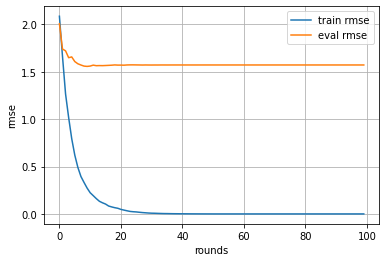

In [19]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')

eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')

plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

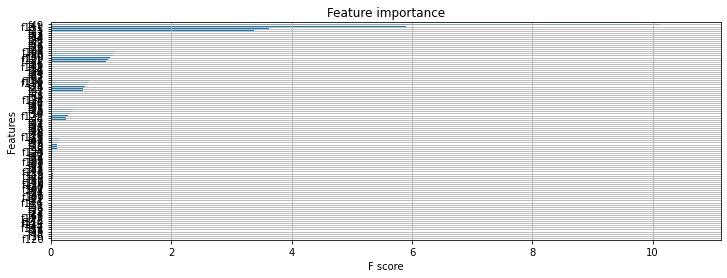

In [20]:
_, ax = plt.subplots(figsize=(12, 4))

xgb.plot_importance(bst,ax=ax,
                    importance_type='gain',
                    show_values=False)

plt.show()

In [21]:
#y_pred.shape

In [22]:
#df_test = laod_data('ranking_test_data.csv')
#print(len(df_test))
#df_test.head(3)

#df_train2 = data_preprocess(df_train)
#df_train2.head(3)

df_test2 = data_preprocess(df_train)
df_test2.head(3)

,category,created_at,updated_at,sum_char_count,sum_new_line_count,sum_talk_char_count,sum_word_count,avg_char_count,avg_new_line_count,avg_talk_char_count,...,wc_その他-間投,wc_名詞-固有名詞-人名-名,wc_助動詞,wc_助詞-接続助詞,wc_名詞-代名詞-一般,wc_副詞-一般,wc_名詞-接続詞的,wc_名詞-固有名詞-組織,wc_記号-句点,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,992220,3078.0,128.0,965.0,...,0,30,4680,2250,900,570,0,0,1830,3.0
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,863400,2596.0,138.0,165.0,...,0,90,4320,1620,1590,390,0,60,2280,4.0
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,628470,1996.0,103.0,341.0,...,0,240,2490,1260,450,360,30,0,930,3.0


In [23]:
# dtest2 = xgb.DMatrix(df_test2)
# dtest2

In [24]:
#y_pred2 = bst.predict(dtest2)